In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import optperfprofpy
import math
from datetime import datetime

In [3]:
# Development tasks
from math import trunc


# TASKS = [
#     "navierstokes",
#     "spherical",
#     "ninapro",
#     "cosmic",
#     "ecg",
#     "deepsea",
#     "nottingham",
#     "crypto",
#     "ember",
#     "fsd50k",
# ]

TASKS = [
    "shallowwater",
    "satellite",
    "sphericaltinyimagenet",
    "jsbchorales",
    "humangait",
    "spokenmnist",
    "stock",
    "myo",
    "year",
    "hpa",
]

FAILED_MAX = 9.99999000e05
SOLVED_MIN = 0.000000e00
SCORE_MIN = 1e-7  # TODO

# Excluded competitors
EXCLUDED_NAMES = [
    "deeplearn",
    #'WRNBaseline',
    "ComboBaseline",
    "DASHBaseline",
    #'DASHbaseline', 'AutoGluonBaseline',
    "TeamDecathlonTeamTest",
    "TeamSTUDENT",
    "cshin23",
]


def post_process_scores(
    df, eps_fail=0.0, eps_solve=0.0, eps_solve_all=False, threshold=False
):
    for _, columnData in df.iteritems():
        failed_inds = np.where(columnData.values == FAILED_MAX)
        if len(failed_inds) > 0:
            columnData.values[failed_inds] = 0
            columnData.values[failed_inds] = np.max(columnData.values) + eps_fail
        # solved_inds = np.where(columnData.values == SOLVED_MIN)
        # if len(solved_inds) > 0 and not eps_solve_all:
        #    columnData.values[solved_inds] = np.inf
        #    columnData.values[solved_inds] = np.min(columnData.values) if eps_solve == 0.0 else eps_solve
        # elif len(solved_inds) > 0 and eps_solve_all:
        #    columnData.values[:] += eps_solve
        min_inds = np.where(columnData.values <= SCORE_MIN)
        if len(min_inds) > 0 and threshold:
            columnData.values[min_inds] = SCORE_MIN
    return df


def unzip(path):
    outdir = path.replace(".zip", "")
    with zipfile.ZipFile(path, "r") as zip_ref:
        zip_ref.extractall(outdir)


def parse_scores(path):
    scores = {}
    with open(path, "r") as f:
        for line in f.readlines():
            for task in TASKS:
                if f"score_{task}" in line:
                    scores[task] = float(line.split(": ")[1])
    # assert(len(scores.keys()) == 10)
    return scores


def average_scores(paths):
    print(f"Averaging: {paths}")
    score_dicts = []
    for path in paths:
        score_dicts.append(parse_scores(path))
    mean_scores = {}
    for task in TASKS:
        items = len(score_dicts)
        mean_scores[task] = 0.0
        for score_dict in score_dicts:
            if score_dict[task] == 999999:
                items -= 1
            else:
                mean_scores[task] += score_dict[task]
        mean_scores[task] /= items
    return mean_scores


def compute_step_area(y, x, prestep=True):
    area = 0.0
    for j in range(1, len(x)):
        width = x[j] - x[j - 1]
        height = y[j] if prestep else y[j - 1]
        area += width * height
    return area


def draw_shaded_perfprof(
    taus,
    solver_vals,
    solvers,
    log=True,
    prestep=False,
    nplot=None,
    plot_inds=None,
    size=None,
):
    """Shaded step plotter for performance profiles with AUPP

    Parameters
    ----------
    taus : numpy.ndarray
        x values of plot.
    solver_vals : numpy.ndarray
        y values of plot.
    solvers : list
        Labels of curves.
    """

    MAX_PER_COL = 10

    if size is not None:
        fig = plt.figure(figsize=size)
    else:
        fig = plt.figure()
    ax = fig.add_subplot(111)

    if log:
        taus = np.log10(taus)

    # Add lines individually to support labels
    aupps = []
    for i, solver in enumerate(solvers):
        aupp = compute_step_area(solver_vals[i, :], taus, prestep=prestep)
        aupps.append(aupp)

    order = np.argsort(aupps)[::-1]
    if nplot is not None:
        num_plotted = min(len(solvers), nplot)
    else:
        num_plotted = len(solvers)
    for j in range(num_plotted):
        if plot_inds is not None and j not in plot_inds:
            continue
        i = order[j]
        solver = solvers[order[j]]
        aupp = aupps[i]
        ax.fill_between(
            x=taus,
            y1=solver_vals[i, :],
            step="pre" if prestep else "post",
            alpha=0.1,
            color=f"C{j%10}",
        )

        ax.step(
            taus,
            solver_vals[i, :],
            where="pre" if prestep else "post",
            label=f"{aupp:.2f} - {solver}",
            linewidth=3,
            alpha=0.5,
            color=f"C{j%10}",
        )

    ncol = (num_plotted // MAX_PER_COL) + 1
    ncol = 1
    if plot_inds is not None:
        ncol = (len(plot_inds) // MAX_PER_COL) + 1
    plt.legend(frameon=False, loc="center left", ncol=ncol, bbox_to_anchor=(1, 0.5))

    plt.xlim(taus.min(), taus.max())
    if not log:
        ax.set_xlabel(r"$\tau$")
        plt.xscale("log")
    else:
        ax.set_xlabel(r"$\log_{10}(\tau)$")
    ax.set_ylabel(r"$\rho_s(\tau)$")
    plt.grid(True, which="both", ls="-", color="0.65", zorder=3, alpha=0.25)
    # ax.set_title(f'Last Updated {datetime.now().strftime("%B %d, %Y, %H:%M CT")}')
    ax.set_title(f"Additional Baseline Results")
    fig.tight_layout()
    plt.savefig("res_test.pdf", bbox_inches="tight")
    plt.plot()

    return aupps, solvers


def plot_scoretable(df_scoretable, log=True, nplot=None, plot_inds=None, size=None):
    # Convert to format ingestible by AUP
    df = pd.DataFrame(df_scoretable.stack()).reset_index()
    df.columns = ["method", "problem", "obj"]
    taus, solver_vals, solvers, transformed_data = optperfprofpy.calc_perprof(
        df, ["problem"], ["obj"], ["method"]
    )
    taus = np.array(taus, dtype=float)
    solver_vals = np.array(solver_vals, dtype=float)
    aupps, solvers = draw_shaded_perfprof(
        taus, solver_vals, solvers, log=log, nplot=nplot, plot_inds=plot_inds, size=size
    )
    return aupps, solvers

Number of problems per solver:  10


/Users/nick11roberts/Library/CloudStorage/Dropbox/My Mac (Nicks-MBP.attlocal.net)/Desktop/optperfprofpy.py:166: UserWarning: Solvers do not solve 100% of problems. Total amount of problems solved: 130.0
  warnings.warn('Solvers do not solve 100% of problems. '


,rank,AUP,shallowwater,satellite,sphericaltinyimagenet,jsbchorales,humangait,spokenmnist,stock,myo,year,hpa
Team TrueFit,1,6.579,0.06975,0.3764,0.9798,0.1228,1e-07,0.006667,0.03247,0.02795,0.004177,0.02193
DASHbaseline,2,6.542,0.03674,0.2689,0.9943,0.1198,1e-07,0.08,0.04854,0.01456,0.003322,0.01849
AutoGluonBaseline,3,6.54,0.0004,0.2445,0.9949,4.134,1e-07,0.01333,0.0832,0.007433,0.00333,0.3871
Team TEG-AutoML,4,6.517,0.04737,0.3003,0.9903,0.111,1e-07,0.006667,0.08221,0.1331,0.003327,0.01904
Team Freiburg-AutoML-Lab,5,6.433,0.0004032,0.2256,0.9896,0.1017,2.281e-06,0.12,0.0412,0.04002,0.003107,0.3883
euxhenh,6,6.359,0.0964,0.4059,0.9965,0.1273,1.171e-05,0.01,0.02083,0.0226,0.003365,0.03017
tak,7,6.268,0.04078,0.2423,0.9895,0.4735,1.087e-07,0.03333,0.04899,0.3742,0.003316,0.2198
automl,8,6.263,0.04607,0.2378,0.995,0.5013,9.417e-07,0.003333,0.05189,0.3742,0.003387,0.2227
Team 42,9,6.231,0.03426,0.246,0.9836,0.516,7.244e-07,0.01,0.06595,0.3742,0.00331,0.2091
Team Paris-Saclay,10,5.856,0.01195,0.2334,0.9949,0.09735,0.9192,0.04333,0.06204,0.008217,0.00304,0.1793


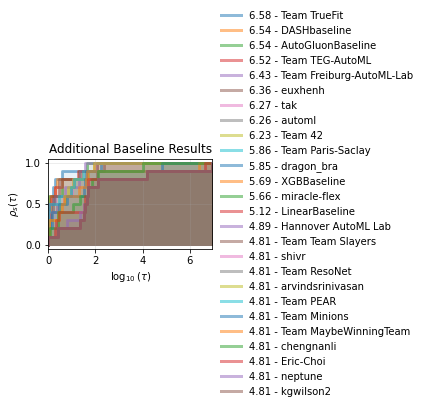

In [4]:
# Load aggregated results file
pd.set_option("display.float_format", "{:.4g}".format)
df_scoretable = pd.read_csv("~/Desktop/test_results.tsv", sep="\t", index_col=0)

# Plot results
aupps, solvers = plot_scoretable(df_scoretable, log=True)
df_scoretable_sorted = df_scoretable.copy()

# Set AUP scores
for aup, solver in zip(aupps, solvers):
    df_scoretable_sorted.at[solver, "AUP"] = aup
# Put AUP first
cols = list(df_scoretable_sorted.columns.values)
df_scoretable_sorted = df_scoretable_sorted[[cols[-1]] + cols[:-1]]
df_scoretable_sorted = df_scoretable_sorted.sort_values("AUP", ascending=False)
# Add rank column
df_scoretable_sorted["rank"] = range(1, len(df_scoretable_sorted) + 1)
# Put rank first
cols = list(df_scoretable_sorted.columns.values)
df_scoretable_sorted = df_scoretable_sorted[[cols[-1]] + cols[:-1]]
df_scoretable_sorted